In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Data preprocessing

In [11]:
df_train = pd.read_csv('Google_Stock_Price_Train.csv')
df_train.head()
train_set = df_train.iloc[:, 1:2].values
train_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [15]:
# Feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Normalization/MinMaxScaler is preferred for RNN 
sc = MinMaxScaler(
    feature_range=(0,1),
    copy=True
)

train_set_scaled = sc.fit_transform(train_set)
train_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [38]:
# Create a data structure with 60 timesteps and 1 output
#      At each timestep, it will look at last 60 timesteps; 60 is what came out of experimentation

# X_train, y_train --> X_train will be last 60 days, y_train will be the next value
X_train = []
y_train = []

for i in range(60, train_set.shape[0]): 
    X_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])
    
# Get these into numpy arrays:
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping data for additional dimensionality;
# i.e., we need to have another dimension for our indicator (google open price, only one dimension)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1), )

# 2. Build the RNN

In [66]:
# import packages and layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Initialize the RNN
regressor = Sequential() 

# add first LSTM layer
regressor.add(LSTM(
    units = 50,
    return_sequences=True, # because we're going to add another LSTM layer, because we're stacking
    input_shape = (X_train.shape[1], 1)

))

# add Dropout layer
regressor.add(Dropout(
    rate=.2 #20% of neurons of the LSTM layer will be ignored; essentially 10 neurons each iteration
))

# add second LSTM layer
regressor.add(LSTM(
    units = 50, 
    return_sequences = True
))

# add second dropout layer
regressor.add(Dropout(rate=0.2))

# add third LSTM layer
regressor.add(LSTM(
    units =50,
    return_sequences=True
))

regressor.add(Dropout(rate=0.2))

# add fourth LSTM layer
regressor.add(LSTM(
    units=50,
    return_sequences=False
))

regressor.add(Dropout(rate=0.2))

regressor.add(Dense(
    units=1
))

regressor.layers

In [71]:
# Compling the RNN with the right optimizer and loss function
regressor.compile(
    optimizer = 'adam', #adam is always a safe choice
    loss = 'mean_squared_error'
)

# Fitting RNN to training 
regressor.fit(
    X_train, 
    y_train,
    epochs=100,
    batch_size= 32 # do this every 32 stock prices
)

Epoch 1/100
38/38 [==============================] - 6s 60ms/step - loss: 0.0423
Epoch 2/100
38/38 [==============================] - 3s 81ms/step - loss: 0.0058
Epoch 3/100
38/38 [==============================] - 3s 89ms/step - loss: 0.0053
Epoch 4/100
38/38 [==============================] - 3s 84ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 4s 113ms/step - loss: 0.0045
Epoch 6/100
38/38 [==============================] - 5s 127ms/step - loss: 0.0049
Epoch 7/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0046
Epoch 8/100
38/38 [==============================] - 5s 120ms/step - loss: 0.0042
Epoch 9/100
38/38 [==============================] - 5s 121ms/step - loss: 0.0043
Epoch 10/100
38/38 [==============================] - 5s 119ms/step - loss: 0.0040
Epoch 11/100
38/38 [==============================] - 3s 92ms/step - loss: 0.0045: 0s - loss:
Epoch 12/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0039
Epoch 1

# 3. Make predictions and visualize

In [105]:
# Get the real stock price -- test data set
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = df_test.iloc[:, 1:2].values

# Predicting stock price

# first concat dataset
dataset_total = pd.concat([
    df_train['Open'], 
    df_test['Open']]
).reset_index()['Open']

inputs = dataset_total[len(dataset_total) - len(df_test) -60: ].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)


X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)

# now we have to inverse the scaling 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

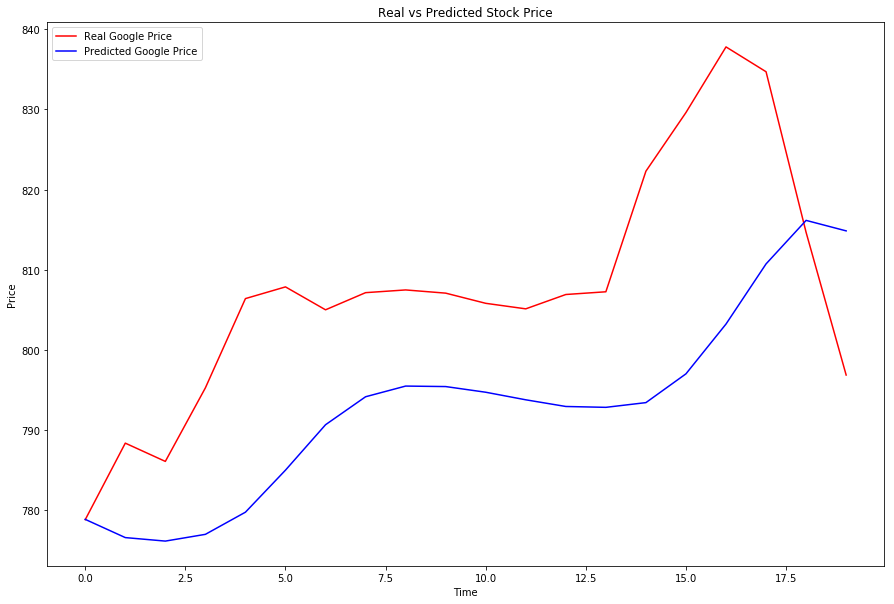

In [123]:
# Visualize results

plt.figure(figsize=(15,10))

plt.plot(real_stock_price, color='red', label='Real Google Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Price')
plt.title('Real vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()